In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import json, io, base64, re, os
import plotly.graph_objects as go
from IPython.display import display, HTML, clear_output
import plotly.express as px
import ipywidgets as widgets
import plotly.graph_objects as go
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
# Initialize settings
import _settings as settings

# Global variables from settings
spec_translate_list = settings.SPEC_TRANSLATE_LIST
plotly_colors = settings.plotly_colors

In [2]:
class DataTransformation:
    def __init__(self):
        self.merged_df = None
        self.proteins_dic = {}
        self.output_area = None
        self.merged_uploader = None

    def create_download_link(self, file_path, label):
        """Create a download link for a file."""
        if os.path.exists(file_path):
            # Read file content and encode it as base64
            with open(file_path, 'rb') as f:
                content = f.read()
            b64_content = base64.b64encode(content).decode('utf-8')

            # Generate the download link HTML
            return widgets.HTML(f"""
                <a download="{os.path.basename(file_path)}" 
                   href="data:application/octet-stream;base64,{b64_content}" 
                   style="color: #0366d6; text-decoration: none; margin-left: 20px; font-size: 14px;">
                    {label}
                </a>
            """)
        else:
            # Show an error message if the file does not exist
            return widgets.HTML(f"""
                <span style="color: red; margin-left: 20px; font-size: 14px;">
                    File "{file_path}" not found!
                </span>
            """)

    def setup_data_loading_ui(self):
        """Initialize and display the data loading UI."""
        # Create file upload widget
        self.merged_uploader = widgets.FileUpload(
            accept='.csv,.txt,.tsv,.xlsx',
            multiple=False,
            description='Upload Data File',
            layout=widgets.Layout(width='300px'),
            style={'description_width': 'initial'}
        )

        self.output_area = widgets.Output()

        # Create upload box with example link
        merged_box = widgets.HBox([
            self.merged_uploader,
            self.create_download_link("example_merged_dataframe.csv", "Example")
        ], layout=widgets.Layout(align_items='center'))

        # Create left column with upload widgets
        upload_widgets = widgets.VBox([
            widgets.HTML("<h3><u>Upload Data File:</u></h3>"),
            merged_box,
            self.output_area
        ], layout=widgets.Layout(
            width='400px',
            margin='0 20px 0 0'
        ))

        # Create container for status display
        self.status_area = widgets.Output(
            layout=widgets.Layout(
                width='400px',
                margin='0 0 0 20px'
            )
        )

        # Create grid layout
        grid = widgets.GridBox(
            [upload_widgets, self.status_area],
            layout=widgets.Layout(
                grid_template_columns='auto auto',
                grid_gap='20px',
                width='900px'
            )
        )

        display(grid)

        # Register observer
        self.merged_uploader.observe(self._on_merged_upload_change, names='value')

    def _validate_and_clean_data(self, df):
        """
        Validate and clean the uploaded data, dropping rows with blank values in key columns.
        Returns tuple of (cleaned_df, warnings, errors)
        """
        warnings = []
        errors = []

        # Check required columns exist
        required_columns = [
            'protein_name',
            'protein_species',
        ]
        
        # Check that at least one Avg_ column exists
        avg_columns = [col for col in df.columns if col.startswith('Avg_')]
        if not avg_columns:
            errors.append("No columns starting with 'Avg_' found in the data")
            return None, warnings, errors
            
        # Add Avg_ columns to required columns
        required_columns.extend(avg_columns)
        
        missing = set(required_columns) - set(df.columns)
        if missing:
            errors.append(f"Missing required columns: {', '.join(missing)}")
            return None, warnings, errors

        cleaned_df = df.copy()

        # Handle blank values by dropping rows and issuing warnings
        for column in required_columns:
            blank_count = cleaned_df[column].isna().sum()
            if blank_count > 0:
                warnings.append(f"Dropping {blank_count} rows with blank values in {column} column")
                cleaned_df = cleaned_df.dropna(subset=[column])

        return cleaned_df, warnings, errors

    def _process_protein_info(self, df):
        """
        Process protein information from the dataframe and store in proteins_dic
        """
        # Group by protein accession to get unique proteins
        protein_info = df.groupby('Master Protein Accessions').agg({
            'protein_name': 'first',
            'protein_species': 'first'
        }).reset_index()

        # Update proteins_dic with the information
        for _, row in protein_info.iterrows():
            protein_id = row['Master Protein Accessions']
            self.proteins_dic[protein_id] = {
                "name": row['protein_name'],
                "species": row['protein_species']
            }

        return len(self.proteins_dic)

    def _load_merged_data(self, file_data):
        """
        Load and validate merged data file
        Returns tuple of (dataframe, status)
        """
        try:
            content = bytes(file_data.content)
            filename = file_data.name
            extension = filename.split('.')[-1].lower()

            file_stream = io.BytesIO(content)

            # Load data based on file extension
            try:
                if extension == 'csv':
                    df = pd.read_csv(file_stream)
                elif extension in ['txt', 'tsv']:
                    df = pd.read_csv(file_stream, delimiter='\t')
                elif extension == 'xlsx':
                    df = pd.read_excel(file_stream)
                else:
                    display(HTML(f'<b style="color:red;">Error: Unsupported file format</b>'))
                    return None, 'no'
            except Exception as e:
                display(HTML(f'<b style="color:red;">Error reading file: {str(e)}</b>'))
                return None, 'no'

            # Validate and clean data
            cleaned_df, warnings, errors = self._validate_and_clean_data(df)

            # Display warnings about dropped rows
            if warnings:
                warning_html = "<br>".join([
                    f'<b style="color:orange;">Warning: {w}</b>'
                    for w in warnings
                ])
                display(HTML(warning_html))

            # Display errors if any
            if errors:
                error_html = "<br>".join([
                    f'<b style="color:red;">Error: {e}</b>'
                    for e in errors
                ])
                display(HTML(error_html))
                return None, 'no'

            if cleaned_df is not None and len(cleaned_df) > 0:
                # Process protein information
                num_proteins = self._process_protein_info(cleaned_df)
                
                # Add information about remaining rows and processed proteins
                display(HTML(
                    f'<b style="color:green;">Processed data contains {len(cleaned_df)} rows '
                    f'after removing blank values.</b><br>'
                    f'<b style="color:green;">Successfully processed information for {num_proteins} unique proteins.</b>'
                ))
                return cleaned_df, 'yes'
            else:
                display(HTML('<b style="color:red;">Error: No valid data rows remaining after cleaning</b>'))
                return None, 'no'

        except Exception as e:
            display(HTML(f'<b style="color:red;">Error processing file: {str(e)}</b>'))
            return None, 'no'

    def _on_merged_upload_change(self, change):
        """Handle merged data file upload"""
        if change['type'] == 'change' and change['name'] == 'value':
            with self.output_area:
                self.output_area.clear_output()
                if change['new'] and len(change['new']) > 0:
                    file_data = change['new'][0]
                    df, status = self._load_merged_data(file_data)
                    if status == 'yes' and df is not None:
                        self.merged_df = df  # Only set merged_df if validation passed
                        display(HTML(
                            f'<b style="color:green;">Data imported successfully with '
                            f'{df.shape[0]} rows and {df.shape[1]} columns.</b>'
                        ))

In [3]:
def generate_download_link(content, filename, filetype='text/html'):
    """Generate a download link for HTML content"""
    if isinstance(content, str):
        content = content.encode()
    b64 = base64.b64encode(content).decode()
    return f"""
        <a download="{filename}" href="data:{filetype};base64,{b64}" class="download-link" 
           style="background-color: #4CAF50;
                  border: none;
                  color: white;
                  padding: 10px 20px;
                  text-align: center;
                  text-decoration: none;
                  display: inline-block;
                  font-size: 14px;
                  margin: 4px 2px;
                  cursor: pointer;
                  border-radius: 4px;">
            Download {filename}
        </a>
    """


In [4]:
class PlotState:
    def __init__(self):
        self.current_state = {
            'uploadedData': None,
            'topProteins': None,
            'groupSelection': None,
            'xLabel': None,
            'yLabel': None,
            'colorScheme': None,
            'lastGenerated': None,
            'buttonsLocked': True
        }
    
    def update_state(self, **kwargs):
        self.current_state.update(kwargs)
        # Lock buttons when state changes
        self.current_state['buttonsLocked'] = True
    
    def generate_completed(self):
        self.current_state['buttonsLocked'] = False
        self.current_state['lastGenerated'] = {
            key: value for key, value in self.current_state.items() 
            if key not in ['lastGenerated', 'buttonsLocked']
        }
    
    def get_state(self):
        return self.current_state


In [20]:
class ProteinPlotter:
    def __init__(self, data_transformer):
        self.data_transformer = data_transformer
        self.plot_output = widgets.Output()
        self.info_output = widgets.Output()
        self.export_output = widgets.Output()
        self.proteins_df = None
        self.sum_df = None
        
        # Initialize state manager first
        self.state_manager = PlotState()
    
        # Create widgets for protein plotting
        self.num_proteins_widget = widgets.IntSlider(
            value=10,
            min=1,
            max=50,
            step=1,
            description='Top Number of Proteins:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        
        # Create widgets for protein plotting
        self.num_proteins_widget = widgets.IntSlider(
            value=10,
            min=1,
            max=50,
            step=1,
            description='Top Number of Proteins:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        
        self.download_plot_button = widgets.Button(
            description='Download Interactive Plot',
            button_style='info',
            icon='file',
            layout=widgets.Layout(width='200px')
        )

        # Create multi-select widget for groups
        self.group_select = widgets.SelectMultiple(
            options=[],
            description='Select Groups:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px', height='100px')
        )
        
        self.plot_button = widgets.Button(
            description='Generate/Update Data',
            button_style='success',
            icon='refresh',
            layout=widgets.Layout(width='200px')
        )
        
        self.export_button = widgets.Button(
            description='Export Data',
            button_style='info',
            icon='download',
            layout=widgets.Layout(width='200px')
        )

        # Add label customization widgets
        self.xlabel_widget = widgets.Text(
            description='X Label:',
            placeholder='Enter x-axis label',
            layout=widgets.Layout(width='400px')
        )
        
        self.ylabel_widget = widgets.Text(
            description='Y Label:',
            placeholder='Enter y-axis label',
            layout=widgets.Layout(width='400px')
        )
        self.legend_widget = widgets.Text(
            description='Legend Title',
            placeholder='Enter a custom legend title',
            layout=widgets.Layout(width='400px')
        )
        self.title_widget = widgets.Text(
            description='Plot Title',
            placeholder='Enter a custom plot title',
            layout=widgets.Layout(width='400px')
        )

        self.color_scheme = widgets.Dropdown(
            options= plotly_colors,
            value='HSV',
            description='Color Scheme:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='400px')
        )
        # Create layout
        self.widget_box = widgets.VBox([
            widgets.HTML("<h4>Plot Controls:</h4>"),
            self.num_proteins_widget,
            self.group_select,
            widgets.HTML("<h4>Appearance Settings:</h4>"),
            self.xlabel_widget,
            self.ylabel_widget,
            self.legend_widget,
            self.title_widget,
            self.color_scheme,
            widgets.HTML("<h4>Actions:</h4>"),
            widgets.HBox([self.plot_button, self.export_button, self.download_plot_button]),
            self.info_output,
            self.plot_output,
            self.export_output
        ])
            
        # Set initial button states
        self.export_button.disabled = True
        self.download_plot_button.disabled = True
        
        def _on_input_change(change):
            self.state_manager.update_state()
            self.export_button.disabled = True
            self.download_plot_button.disabled = True
        
        # Add observers for input changes
        self.num_proteins_widget.observe(_on_input_change, names='value')
        self.group_select.observe(_on_input_change, names='value')
        self.xlabel_widget.observe(_on_input_change, names='value')
        self.ylabel_widget.observe(_on_input_change, names='value')
        self.legend_widget.observe(_on_input_change, names='value')
        self.title_widget.observe(_on_input_change, names='value')
        self.color_scheme.observe(_on_input_change, names='value')

        # Add button click handlers
        self.plot_button.on_click(self._on_plot_button_click)
        self.export_button.on_click(self._on_export_button_click)
        self.download_plot_button.on_click(self._on_download_plot_click)
        
        # Add variable to store current figure
        self.current_fig = None
        # Add observer for data changes
        self.data_transformer.merged_uploader.observe(self._update_group_options, names='value')

    def _get_avg_columns(self):
        """Get all columns that start with 'Avg_' from the merged dataframe"""
        if self.data_transformer.merged_df is not None:
            return [col for col in self.data_transformer.merged_df.columns if col.startswith('Avg_')]
        return []

    def _update_group_options(self, change):
        """Update group selection options when data changes"""
        if self.data_transformer.merged_df is not None:
            avg_columns = self._get_avg_columns()
            # Remove 'Avg_' prefix for display
            group_options = [col.replace('Avg_', '') for col in avg_columns]
            self.group_select.options = group_options
            # Select all groups by default
            self.group_select.value = group_options

    def process_data(self, selected_groups=None):
        """Process data with optional group selection"""
        if self.data_transformer.merged_df is None or not self.data_transformer.proteins_dic:
            return False
        df = pd.read_csv("protein_df.csv")
        df = self.data_transformer.merged_df.copy()
        
        # Get Absorbance columns based on selected groups
        if selected_groups:
            Absorbance_cols = [f'Avg_{var}' for var in selected_groups]
        else:
            Absorbance_cols = self._get_avg_columns()
            
        df['Total_Absorbance'] = df[Absorbance_cols].sum(axis=1).astype(int)
        
        # Filter out zero Absorbance entries
        result_df = df[['unique ID', 'Total_Absorbance']]
        result_df = result_df[result_df['Total_Absorbance'] == 0]
        all_zero_list = list(result_df['unique ID'])
        peptides_df = df[~df['unique ID'].isin(all_zero_list)]

        # Process protein positions and create proteins DataFrame
        additional_columns = ['Master Protein Accessions', 'unique ID', 'Description']
        selected_columns = additional_columns + Absorbance_cols
        
        
        temp_df = peptides_df.copy()
        temp_df.loc[:, 'Protein_ID'] = temp_df['Master Protein Accessions']
        # Create proteins DataFrame with selected columns
        self.proteins_df = temp_df.groupby('Protein_ID').agg(
            {
                **{col: 'first' for col in ['Master Protein Accessions', 'Description']},
                **{col: 'sum' for col in Absorbance_cols}
            }
        ).reset_index()
        
        # Calculate relative Absorbance for selected groups
        for col in Absorbance_cols:
            col_sum = self.proteins_df[col].sum()
            if col_sum > 0:  # Avoid division by zero
                self.proteins_df[f'Rel_{col}'] = (self.proteins_df[col] / col_sum) * 100
            else:
                self.proteins_df[f'Rel_{col}'] = 0
            
        # Create sum DataFrame for selected groups
        self.sum_df = pd.DataFrame({
            'Sample': Absorbance_cols,
            'Total_Sum': [self.proteins_df[col].sum() for col in Absorbance_cols]
        })
        
       
        #self.proteins_df['Description'] = df['protein_name']

        
        return True

    
    def plot_stacked_bar_scaled(self, pro_list, title, selected_groups):
        if self.proteins_df is None or self.sum_df is None:
            return None
                
        scaled_df = self.proteins_df.copy()
        print(scaled_df.columns)
        # Filter for selected groups
        sample_orders = [f'Rel_Avg_{var}' for var in selected_groups]
        
        # Create sample mapping for selected groups
        sample_mapping = {
            f'Rel_Avg_{var}': f'Avg_{var}' for var in selected_groups
        }
        
        # Convert relative absorbance columns to percentages
        for col in sample_orders:
            scaled_df[col] = self.proteins_df[col] * 100
                
        # Scale absolute Absorbance
        for col in sample_orders:
            sample_key = sample_mapping[col]
            total_sum = self.sum_df.loc[self.sum_df['Sample'] == sample_key, 'Total_Sum'].values[0]
            if total_sum > 0:
                scaled_df[col] = self.proteins_df[col] * total_sum / self.proteins_df[col].sum()
        
        # Sort proteins_df based on pro_list
        description_order = {desc: i for i, desc in enumerate(pro_list)}
        scaled_df['Order'] = scaled_df['Description'].map(description_order)
        scaled_df = scaled_df.sort_values(by='Order').reset_index(drop=True)
        
        # Generate shades for each protein with corrected color names
        color_mapping = {
                'Shared - Beta-casein': 'forestgreen',      # Close to 'fern green'
                'Bovine - Beta-casein': 'limegreen',       # Close to 'bright lime'
                'Human - Beta-casein': 'lightgreen',       # Close to 'light aquamarine'
                'Shared - Lactotransferrin': 'orange',     # Close to 'bright lilac'
                'Human - Lactotransferrin': 'navajowhite',# Close to 'greyish purple'
                'Shared - Alpha-lactalbumin': 'firebrick',     # Close to 'red brown'
                'Bovine - Alpha-lactalbumin': 'orangered',      # Close to 'rose pink'
                'Human - Alpha-lactalbumin': 'salmon',   # Close to 'neon pink'
                'Bovine - Alpha-S1-casein': 'royalblue',        # Close to 'cobalt blue'
                'Human - Alpha-S1-casein': 'skyblue',    # Close to 'dirty blue'
                'Bovine - Beta-lactoglobulin': 'darkgray'  # Close to 'charcoal'
            }

        
        # Create figure object before adding traces
        fig = go.Figure()
      
        for idx, row in scaled_df.iterrows():
            protein_description = row['Description']
            if protein_description in pro_list:
                
                hover_text = []
                for sample in sample_orders:
                    abs_col = sample_mapping[sample]
                    rel_value = self.proteins_df.loc[idx, sample]
                    rel_value_hov = self.proteins_df.loc[self.proteins_df['Description'] == protein_description, sample].values[0]
                    abs_value = row[abs_col]
                    hover_text.append(
                        f"Description: {protein_description}<br>" +
                        f"Sample: {sample.replace('Rel_Avg_', '')}<br>" +
                        f"Relative Absorbance: {rel_value_hov:.2f}%<br>" +
                        f"Absolute Absorbance: {abs_value:.2e}"
                    )
                
                fig.add_trace(go.Bar(
                    name=protein_description,
                    x=[label.replace('Rel_Avg_', '') for label in sample_orders],
                    y=row[sample_orders],
                    marker_color=color_mapping[protein_description],
                    hovertext=hover_text,
                    hoverinfo='text'
                ))

        # Get custom labels
        x_label = self.xlabel_widget.value or 'Sample Type'
        y_label = self.ylabel_widget.value or 'Scaled Absolute Absorbance'
        plot_title = self.title_widget.value or ''
        legend_title = self.legend_widget.value or 'Protein Origins:'
                                
        fig.update_layout(
            barmode='stack',
            title={
                'text': plot_title,
                'y': 0.95,
                'x': 0.5,
                'xanchor': 'center',
                'yanchor': 'top',
                'font': {'size': 15, 'color': 'black'}  # Black title text
            },
            xaxis_title=x_label,
            yaxis_title=y_label,
            legend_title=legend_title,
            legend=dict(
                yanchor="top",
                y=1,
                xanchor="left",
                x=1.05,
                font=dict(size=14, color='black')  # Black legend text
            ),
            showlegend=True,
            template='plotly_white',
            height=600,
            width=1000,
            margin=dict(t=100, l=100, r=200),
            hoverlabel=dict(
                bgcolor="white",
                font_size=14,  # Hover text size
                font_family="Arial",
                font_color="black"  # Black hover text
            )
        )
        
        # Customize x-axis
        fig.update_xaxes(
            title_font={"size": 15, "color": "black"},  # Black x-axis title
            tickfont={"size": 14, "color": "black"},   # Black x-axis tick labels
            showline=True,  # Display bottom spine
            linecolor="black",  # Black bottom spine
            mirror=False  # Do not mirror to the top
        )
        
        # Customize y-axis
        fig.update_yaxes(
            title_font={"size": 15, "color": "black"},  # Black y-axis title
            tickfont={"size": 14, "color": "black"},   # Black y-axis tick labels
            exponentformat='E',
            showexponent='all',
            showline=True,  # Display left spine
            linecolor="black",  # Black left spine
            range=[0, 5e10]  # Force y-axis range to [0, 5 * 10^10]
        )

            
        # Mark generation as complete
        self.state_manager.generate_completed()
        self.export_button.disabled = False
        self.download_plot_button.disabled = False
        
        return fig

    def _on_plot_button_click(self, b):
        if self.current_fig is not None:
            self.state_manager.generate_completed()
            self.export_button.disabled = False
            self.download_plot_button.disabled = False
        with self.plot_output:
            self.plot_output.clear_output(wait=True)
            
            if not self.group_select.value:
                print("Please select at least one group to plot.")
                return
            
            selected_groups = list(self.group_select.value)
            if self.process_data(selected_groups):
                # Calculate average Absorbance for sorting using only selected groups
                selected_rel_columns = [f'Rel_Avg_{var}' for var in selected_groups]
                self.proteins_df['avg_absorbance_all'] = self.proteins_df[selected_rel_columns].mean(axis=1)
                
                # Sort and get top N proteins
                sorted_proteins = self.proteins_df.sort_values('avg_absorbance_all', ascending=False)
                #pro_list = list(sorted_proteins['Description'].head(self.num_proteins_widget.value))
                pro_list = [
                            "Shared - Beta-casein",
                            "Bovine - Beta-casein",
                            "Human - Beta-casein",
                            "Shared - Lactotransferrin",
                            "Human - Lactotransferrin",
                            "Shared - Alpha-lactalbumin",
                            "Bovine - Alpha-lactalbumin",
                            "Human - Alpha-lactalbumin",
                            #"Shared - Osteopontin",
                            #"Bovine - Osteopontin",
                            #"Human - Osteopontin",
                            #"Shared - Actin",
                            #"Bovine - Kappa-casein",
                            #"Bovine - Alpha-S2-casein",
                            "Bovine - Alpha-S1-casein",
                            "Human - Alpha-S1-casein",
                            "Bovine - Beta-lactoglobulin"
                        ]
                # Create and store plot
                self.current_fig = self.plot_stacked_bar_scaled(
                    pro_list=pro_list,
                    title='',
                    selected_groups=selected_groups
                )
                if self.current_fig is not None:
                    self.current_fig.show()
            else:
                print("Please upload all required files first.")
                print("Error creating plot. Please check your data.")
    
    def generate_download_link(self, content, filename, filetype='text/csv'):
        """Generate a download link for any content"""
        if isinstance(content, pd.DataFrame):
            if filetype == 'text/csv':
                content = content.to_csv(index=False)
            else:
                content = content.to_csv(index=True)
        if isinstance(content, str):
            content = content.encode()
        b64 = base64.b64encode(content).decode()
        return f"""
            <a id="download_link" href="data:{filetype};base64,{b64}" 
               download="{filename}"
               style="display: none;">
                Download {filename}
            </a>
            <script>
                document.getElementById('download_link').click();
            </script>
            """
    
    def _on_download_plot_click(self, b):
        """Handle plot download button click with automatic download"""
        if self.current_fig is not None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            plot_filename = f'protein_plot_{timestamp}.html'
            
            with self.export_output:
                self.export_output.clear_output(wait=True)
                display(HTML(self.generate_download_link(
                    self.current_fig.to_html(),
                    plot_filename,
                    'text/html'
                )))
        else:
            print("Please generate a plot first.")
    
    def _on_export_button_click(self, b):
        """Handle data export with automatic download"""
        if self.proteins_df is not None:
            timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
            data_filename = f'protein_absorbance_analysis_{timestamp}.csv'
            
            with self.export_output:
                self.export_output.clear_output(wait=True)
                display(HTML(self.generate_download_link(
                    self.proteins_df,
                    data_filename,
                    'text/csv'
                )))
        else:
            print("Please generate the analysis first.")

    def display(self):
        """Display the protein analysis interface"""
        display(self.widget_box)


# Initialize the interface
data_transformer = DataTransformation()
data_transformer.setup_data_loading_ui()

# Create protein plotter
protein_plotter = ProteinPlotter(data_transformer)
protein_plotter.display()

GridBox(children=(VBox(children=(HTML(value='<h3><u>Upload Data File:</u></h3>'), HBox(children=(FileUpload(va…

{'Shared - Beta-casein': 'forestgreen', 'Bovine - Beta-casein': 'limegreen', 'Human - Beta-casein': 'lightgreen', 'Shared - Lactotransferrin': 'orange', 'Human - Lactotransferrin': 'navajowhite', 'Shared - Alpha-lactalbumin': 'firebrick', 'Bovine - Alpha-lactalbumin': 'orangered', 'Human - Alpha-lactalbumin': 'salmon', 'Bovine - Alpha-S1-casein': 'royalblue', 'Human - Alpha-S1-casein': 'skyblue', 'Bovine - Beta-lactoglobulin': 'darkgray'}


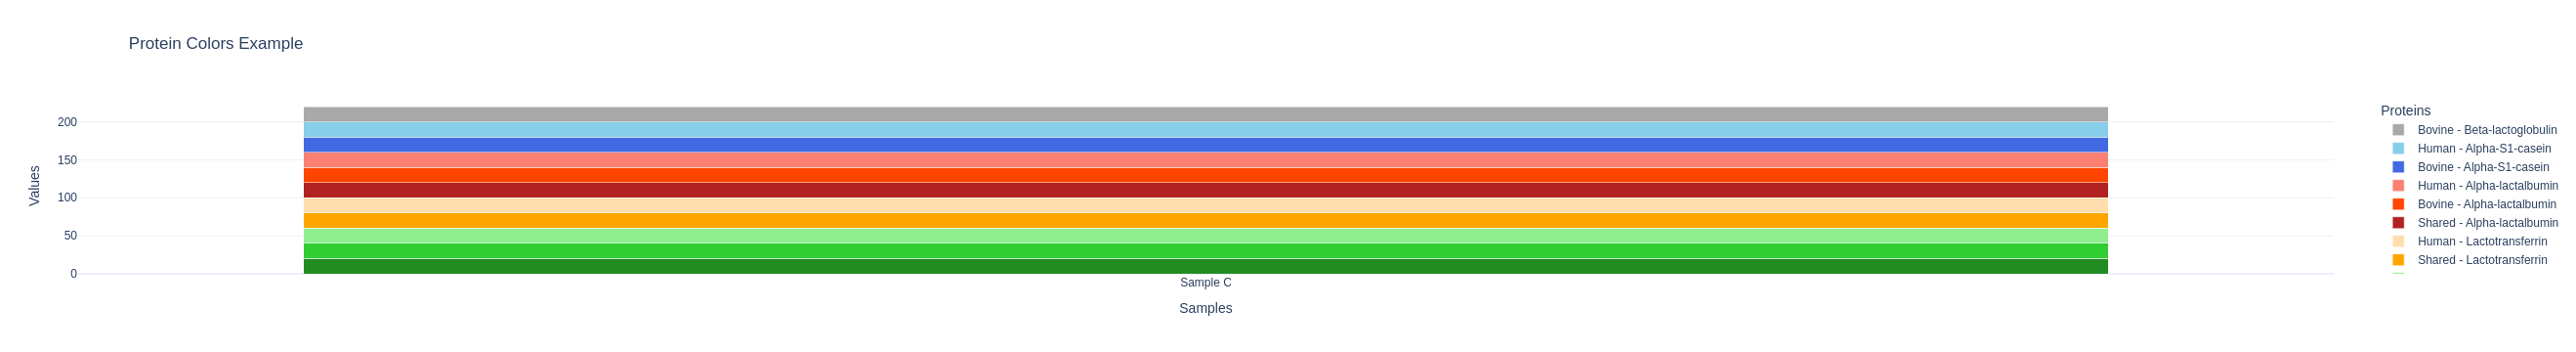

In [15]:
pro_list = [
            "Shared - Beta-casein",
            "Bovine - Beta-casein",
            "Human - Beta-casein",
            "Shared - Lactotransferrin",
            "Human - Lactotransferrin",
            "Shared - Alpha-lactalbumin",
            "Bovine - Alpha-lactalbumin",
            "Human - Alpha-lactalbumin",
            #"Shared - Osteopontin",
            #"Bovine - Osteopontin",
            #"Human - Osteopontin",
            #"Shared - Actin",
            #"Bovine - Kappa-casein",
            #"Bovine - Alpha-S2-casein",
            "Bovine - Alpha-S1-casein",
            "Human - Alpha-S1-casein",
            "Bovine - Beta-lactoglobulin"
        ]
# Use the tab20 colormap
tab20_colors = plt.cm.tab20.colors

# Mapping protein types to specific shades from tab20
base_colors = {
    "Beta-casein": tab20_colors[0],        # Blue shades
    "Lactotransferrin": tab20_colors[2],   # Green shades
    "Alpha-lactalbumin": tab20_colors[4],  # Orange shades
    "Alpha-S1-casein": tab20_colors[6],    # Purple shades
    "Beta-lactoglobulin": tab20_colors[8]  # Brown shades
}

# Generate shades for each protein with corrected color names
color_mapping = {
    'Shared - Beta-casein': 'forestgreen',      # Close to 'fern green'
    'Bovine - Beta-casein': 'limegreen',       # Close to 'bright lime'
    'Human - Beta-casein': 'lightgreen',       # Close to 'light aquamarine'
    'Shared - Lactotransferrin': 'orange',     # Close to 'bright lilac'
    'Human - Lactotransferrin': 'navajowhite',# Close to 'greyish purple'
    'Shared - Alpha-lactalbumin': 'firebrick',     # Close to 'red brown'
    'Bovine - Alpha-lactalbumin': 'orangered',      # Close to 'rose pink'
    'Human - Alpha-lactalbumin': 'salmon',   # Close to 'neon pink'
    'Bovine - Alpha-S1-casein': 'royalblue',        # Close to 'cobalt blue'
    'Human - Alpha-S1-casein': 'skyblue',    # Close to 'dirty blue'
    'Bovine - Beta-lactoglobulin': 'darkgray'  # Close to 'charcoal'
}

# Example of the resulting color mapping
print(color_mapping)




# Create a bar chart with dummy data for each protein
fig = go.Figure()

for protein, color in color_mapping.items():
    # Add a bar for each protein
    fig.add_trace(
        go.Bar(
            name=protein,  # Legend entry
            x=["Sample C"],  # Example x-axis values
            y=[20],  # Example y-axis values
            marker_color=color,  # Assign the color from the mapping
            hoverinfo="text",
            hovertext=f"{protein}<br>Color: {color}"
        )
    )

# Update the layout
fig.update_layout(
    title="Protein Colors Example",
    xaxis_title="Samples",
    yaxis_title="Values",
    legend_title="Proteins",
    barmode="stack",  # Stack bars for better visual comparison
    template="plotly_white"
)

# Show the figure
fig.show()